# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #2:
- Task 1: Dependencies and OpenAI API Key
- Task 2: LangGraph RAG
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset
- Task 6: Evaluation

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for our simple RAG system that leverages Loand Complaint data.

In [59]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

#### Asyncio Bug Handling

In [60]:
import nest_asyncio
nest_asyncio.apply()

## Task #2: Create a Simple RAG Application Using LangGraph

Let's remake our LangGraph RAG pipeline from the first notebook!

## LangGraph Powered RAG

First and foremost, LangChain provides a convenient way to store our chunks and their embeddings.

It's called a `VectorStore`!

We'll be using QDrant as our `VectorStore` today. You can read more about it [here](https://qdrant.tech/documentation/).

Think of a `VectorStore` as a smart way to house your chunks and their associated embedding vectors. The implementation of the `VectorStore` also allows for smarter and more efficient search of our embedding vectors - as the method we used above would not scale well as we got into the millions of chunks.

Otherwise, the process remains relatively similar under the hood!

### Data Collection

We'll be leveraging the `DirectoryLoader` to load our PDFs!

In [61]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

loan_knowledge_resources = directory_loader.load()

### Chunking Our Documents

Let's do the same process as we did before with our `RecursiveCharacterTextSplitter` - but this time we'll use ~200 tokens as our max chunk size!

In [62]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 200,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)
loan_knowledge_chunks = text_splitter.split_documents(loan_knowledge_resources)

In [63]:
len(loan_knowledge_chunks)

1088

Let's verify the process worked as intended by checking our max document length.

In [64]:
max_chunk_length = 0

for chunk in loan_knowledge_chunks:
  max_chunk_length = max(max_chunk_length, tiktoken_len(chunk.page_content))

print(max_chunk_length)

199


Perfect! Now we can carry on to creating and storing our embeddings.

### Embeddings and Vector Storage

We'll use the `text-embedding-3-small` embedding model again - and `Qdrant` to store all our embedding vectors for easy retrieval later!

In [65]:
from langchain_community.vectorstores import Qdrant
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

qdrant_vectorstore = Qdrant.from_documents(
    documents=loan_knowledge_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Now let's set up our retriever, just as we saw before, but this time using LangChain's simple `as_retriever()` method!

In [66]:
qdrant_retriever = qdrant_vectorstore.as_retriever(search_kwargs={"k": 4})
# added k= something (default is 4)

#### Back to the Flow

We're ready to move to the next step!

### Setting up our RAG

We'll use the same LangGraph pipeline we created in the first notebook. 

Let's think through each part:

1. First we need to retrieve context
2. We need to pipe that context to our model
3. We need to parse that output

Let's start by setting up our prompt again, just so it's fresh in our minds!

#### 🏗️ Activity #2:

Complete the prompt so that your RAG application answers queries based on the context provided, but *does not* answer queries if the context is unrelated to the query.

In [67]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context respond exactly with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

We'll set our Generator - `gpt-4.1-nano` in this case - below!

In [68]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

#### Our RAG Application

Let's spin up the graph.

In [69]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

Let's get a visual understanding of our chain!

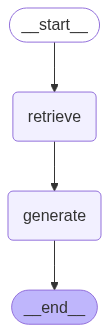

In [70]:
rag_graph

Let's test our chain out!

In [71]:
response = rag_graph.invoke({"question" : "Is applying for and securing a student loan in 2025 a terrible idea?"})

In [72]:
response["response"]

"I don't know"

In [73]:
for context in response["context"]:
  print("Context:")
  print(context.page_content[:100])
  print("----")

Context:
the 2025-26 award year. Students may update the answer to this question if their plans change or the
----
Context:
Deadlines
The application processing cycle typically lasts 21 months, with the FAFSA form opening on
----
Context:
2025-26 is published, the corresponding deadline date is expected to be mid-September 2026. Applican
----
Context:
received a prior Direct Subsidized Loan, Direct Unsubsidized Loan, Subsidized Federal Stafford Loan,
----


Let's see if it can handle a query that is totally unrelated to the source documents.

In [74]:
response = rag_graph.invoke({"question" : "What is the airspeed velocity of an unladen swallow?"})

In [75]:
response["response"]

"I don't know"

## Task 3: Setting Up LangSmith

Now that we have a chain - we're ready to get started with LangSmith!

We're going to go ahead and use the following `env` variables to get our Colab notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [76]:
#from uuid import uuid4
#only run above once, then re-use UID, for consistency
unique_id = uuid4().hex[0:8]

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = f"LangSmith - {unique_id}"

In [77]:
print(os.environ["LANGSMITH_PROJECT"])
#capture the UUID from first call to unique_id, to save for future

LangSmith - 7173dd4a


capturing UUID for continued use: 
LangSmith - b1cea92f

In [78]:
# Setting up a stable UUID for this project
unique1_id = "b1cea92f"  # reuse this one for consistency
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = f"LangSmith - {unique1_id}"


### LangSmith API

In order to use LangSmith - you will need an API key. You can sign up for a free account on [LangSmith's homepage!](https://www.langchain.com/langsmith)

Once you have created your account, Take the navigation option for `Settings` then `API Keys` to create an API key.

In [79]:
os.environ["LANGSMITH_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

In [83]:
# Recreate the graph after LangSmith setup to enable tracing
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

# Recreate the graph with LangSmith tracing enabled
graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

print("Graph recreated with LangSmith tracing enabled!")


Graph recreated with LangSmith tracing enabled!


Let's test our our first generation!

In [ ]:
# Correct way to enable LangSmith tracing for LangGraph (from Cursor/Claude)
# Method 1: Using explicit tracer configuration
from langchain_core.tracers import LangChainTracer

tracer = LangChainTracer()
tracer.project_name = os.environ["LANGSMITH_PROJECT"]

# Test with proper configuration
response = rag_graph.invoke(
    {"question": "What is the maximum loan amount I can get from the government to go to school these days?"}, 
    config={
        "tags": ["Demo Run"],
        "callbacks": [tracer]
    }
)
print("Response:", response['response'])
print("This should now appear in LangSmith!")


Response: The maximum loan amount you can receive from the government depends on your student status and the type of loan. For a dependent first-year undergraduate student enrolled in a 900 clock-hour program, the combined subsidized and unsubsidized annual loan limit is $5,500, with no more than $3,500 of that being subsidized. Each loan is paid in two disbursements. 

For graduate and professional students, the maximum combined subsidized and unsubsidized loan limit is $138,500, which includes undergraduate loans, with no more than $65,500 of this amount being subsidized.

In the final period of study (such as fall and spring terms), the prorated combined loan limit is approximately $8,375, with no more than $3,685 of that amount being subsidized.

Overall, the maximum loan amounts vary based on your specific circumstances, but these are the limits specified in the provided document.
This should now appear in LangSmith!


In [84]:
rag_graph.invoke({"question" : "What is the maximum loan amount I can get from the government to go to school these days?"}, {"tags" : ["Demo Run"]})['response']

"The maximum loan amount you can receive from the government depends on your status and the type of loan. For a dependent first-year undergraduate student enrolled in a 900 clock-hour program, the combined subsidized and unsubsidized annual loan limit is $5,500, with no more than $3,500 of this amount being subsidized. Each loan is paid in two disbursements of $1,750 each.\n\nFor graduate and professional students, the combined subsidized and unsubsidized loan limit is up to $138,500, with no more than $65,500 of this amount being subsidized loans.\n\nAdditionally, the overall loan limits include previous borrowing, and for students in their final period of study (such as fall and spring terms), the prorated limits apply based on the number of months remaining, with specific amounts detailed for subsidized and unsubsidized loans.\n\nI don't know an exact maximum total loan amount you can get at this moment without more specific details about your status."

In [87]:
# Test with unrelated question (should return "I don't know")
response = rag_graph.invoke(
    {"question": "Who is Batman?"}, 
    config={
        "tags": ["Batman Test"],
        "callbacks": [tracer]
    }
)
print("Response:", response['response'])
print("This should also appear in LangSmith!") #it did!


Response: I don't know
This should also appear in LangSmith!


LDC 5-July-25: Added some debugging cells to find out why traces aren't showing up in Langsmith

In [81]:
#added to debug why langsmith is not tracing
print(os.environ["LANGSMITH_PROJECT"])
print(os.environ["LANGSMITH_TRACING"])


LangSmith - b1cea92f
true


In [ ]:
#added for debugging and testing
rag_graph.invoke({"question" : "Who is Batman"}, {"tags" : ["Batman Test"]})['response']

"I don't know"

In [55]:
from langsmith import Client

client = Client()

print(client.list_projects())


<generator object Client.list_projects at 0x12bec3d80>


In [56]:
for project in client.list_projects():
    print(project)


id=UUID('19d39b2b-d01b-4ed8-a618-5f8637f14ead') start_time=datetime.datetime(2025, 7, 3, 22, 29, 20, 973000, tzinfo=datetime.timezone.utc) end_time=None description=None name='default' extra=None tenant_id=UUID('6a26aaa0-1b14-4cdb-933f-5cb4da328a84') reference_dataset_id=None


In [ ]:
#test of direct LangSmith tracing, without the graph (it worked)
from langchain_core.tracers import LangChainTracer
from langchain_openai import ChatOpenAI

tracer = LangChainTracer()
tracer.project_name = "LangSmith - b1cea92f"

chat = ChatOpenAI(model="gpt-4o-mini", callbacks=[tracer])

response = chat.invoke("Hello with explicit tracer!")
print(response)


content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 12, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bq0ZwJsVttFPXEpLZXVDXVlEYgHc6', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--5ef1555a-dd5f-4d82-8d4b-d3fa27bfe2f3-0' usage_metadata={'input_tokens': 12, 'output_tokens': 9, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.

![LangSmith trace](LangSmithTraceScreenshot_2025-07-05.png)

The screenshot image shows:
The steps (flow) of the LangGraph (retrieve and generate)
How long each step took
What tools were called (VectorStoreRetriever, ChatOpenAI gpt-4.1nano)
how many tokens were passed, and the cost
The text of the question and of the response
The number of documents (chunks) returned
The initial text of each of the documents
Run metrics, including start & end time
The token length of each chunk (71, +16, which is some kind of 'overlap' number, that I don't really understand)

## Task 5: Loading Our Testing Set

In [21]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

Cloning into 'DataRepository'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 122 (delta 37), reused 39 (delta 10), pack-reused 8 (from 1)
Receiving objects: 100% (122/122), 78.04 MiB | 2.97 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [88]:
import pandas as pd

test_df = pd.read_csv("DataRepository/student_loan_rag_test_data.csv")

In [ ]:
#debug cell
test_df.head()

In [99]:
#debug cell
print(dataset_name)
print(test_df.shape)
print(rag_graph)


langsmith-student-loan-rag
(23, 5)


Now we can set up our LangSmith client - and we'll add the above created dataset to our LangSmith instance!

> NOTE: Read more about this process [here](https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets#create-from-list-of-values)

In [90]:
from langsmith import Client

client = Client()

dataset_name = "langsmith-student-loan-rag"

dataset = client.create_dataset(
    dataset_name=dataset_name, description="Student Loan RAG Test Questions"
)

for triplet in test_df.iterrows():
  triplet = triplet[1]
  client.create_example(
      inputs={"question" : triplet["question"], "context": triplet["context"]},
      outputs={"answer" : triplet["answer"]},
      dataset_id=dataset.id
  )

## Task 6: Evaluation

Now we can run the evaluation!

We'll need to start by preparing some custom data preparation functions to ensure our chain works with the expected inputs/outputs from the `evaluate` process in LangSmith.

> NOTE: More reading on this available [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#evaluate-a-langchain-runnable)

In [91]:
def prepare_data_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.outputs["answer"],
      "input" : example.inputs["question"]
  }

def prepare_data_noref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "input" : example.inputs["question"]
  }

def prepare_context_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.inputs["context"],
      "input" : example.inputs["question"]
  }

We'll be using a few custom evaluators to evaluate our pipeline, as well as a few "built in" methods!

Check out the built-ins [here](https://docs.smith.langchain.com/reference/sdk_reference/langchain_evaluators)!

In [101]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

eval_llm = ChatOpenAI(model="gpt-4o-mini", tags=["eval_llm"])

cot_qa_evaluator = LangChainStringEvaluator("cot_qa",  config={"llm":eval_llm}, prepare_data=prepare_context_ref)

# labeled_score_evaluator = LangChainStringEvaluator(
#     "labeled_score_string",
#     config={
#         "criteria": {
#             "accuracy": "Is the generated answer acceptable? Respond with Yes or No"
#         },
#         "llm" : eval_llm,
#     },
#     prepare_data=prepare_data_ref
# )

unlabeled_dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria" : {
            "dopeness" : "Is the answer to the question dope, meaning wicked cool - super awesome - and legit?"
        },
        "llm" : eval_llm,
    },
    prepare_data=prepare_data_noref
)

labeled_score_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": {
            "accuracy": "Is the generated answer the same as the reference answer?"
        },
        "llm" : eval_llm,
    },
    prepare_data=prepare_data_ref
)

base_rag_results = evaluate(
    rag_graph.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        ],
    experiment_prefix="Base RAG Evaluation V2"
)

View the evaluation results for experiment: 'Base RAG Evaluation V2-fa88c6ca' at:
https://smith.langchain.com/o/6a26aaa0-1b14-4cdb-933f-5cb4da328a84/datasets/e09e2c54-c73d-4fe7-bf4c-a181cf8b8b8a/compare?selectedSessions=a5a36f54-175e-4524-a25b-f36b21733f0f




0it [00:00, ?it/s]

#### ❓Question #1:

What conclusions can you draw about the above results?

Describe in your own words what the metrics are expressing.

#### Answer:

The rows in the evaluation output match the data set, showing the questions and “correct” (reference) answers.
LangChain compares the RAG output to each of the questions against the reference answers and “evaluates” the result, based on the particular criteria of each “evaluation class” (either a standard template such as COT, or a custom provided criteria).

#### Additional observations / experiments
It didn’t sink in for me until  this exercise how subjective the evaluation process can be. It is subjective, both because of the criteria we provide and because of how the LLM applies the criteria.

It was also an awakening to realize that the eval is being done by an LLM. (But of course, that is required for scale.) We provide the criteria, but the LLM evaluates how well the RAG output matches the criteria, and also determines the pass/fail threshold.

I was puzzled as to how one evaluates the accuracy of the evaluation?

I didn’t want to try to evaluate the evaluation of the COT or labeled score evaluator, so I decided to review the dopeness score. In my opinion, there wasn’t  much dopeness in any of the responses that I checked. The LLM was much more generous than me, giving about a third of the responses a passing grade on dopeness. I tried to crank up the dopenesss threshold by changing the criteria from “”cool and awesome” to “wicket cool and super awesome”. With that change, the pass rate dropped from 7 out of 23 to 5 out of 23 (with LangChain giving an average dopeness score of .17, down from .33).
So, I did see how the criteria (subjectively) influences the outcome.

Seems to me that if a RAG system performs poorly, or not in line with expectations on an eval, first you have to evaluate the evaluation criteria before addressing the RAG. Or, use more objective criteria.

Once confident in the eval criteria, you would have to “tune” the RAG app.From what I’ve learned so far, the most relevant tunable would be the chunking strategy / chunk size, the number of context matches reviewed (“k”), and perhaps most importantly, the quality, or relevance, of the data used for the vector store. 


#### P.S.:


initially, my rag_graph was not tracing in LangSmith.
I added some debugging cells to confirm that my API key was valid, and that I could trace a query outside of the LangGraph pipeline. Then I got Claude to help me, and this is what **Claude** said/did:


*"The Complete Problem:
Timing Issue: Your rag_graph was compiled in cell 28, but LangSmith wasn't configured until cells 42-44. When a graph is compiled, it captures the current environment state.
Syntax Issue: The invoke calls had incorrect syntax - rag_graph.invoke({...}, {"tags": [...]}) instead of config={"tags": [...]}
Environment Variable Issue: LangGraph doesn't automatically pick up LANGSMITH_TRACING environment variables like some other LangChain components do.
Why My Solution Addresses All Three:
The explicit callback approach I provided (callbacks=[tracer]) actually solves all three issues simultaneously:
✅ Timing: By explicitly creating a tracer at runtime, we bypass the timing issue entirely
✅ Syntax: Uses correct config= parameter syntax
✅ Environment Variables: Explicit tracer configuration instead of relying on auto-detection
Alternative Solutions:
If you wanted to address just the timing issue, you could:
Apply to LangSmith_an...
)
But this approach is less reliable because:
LangGraph still might not pick up the environment variables automatically
You'd still need to fix the syntax errors in your invoke calls
The Most Robust Solution:
The explicit callback approach I provided is actually the most reliable because:
It works regardless of when the graph was compiled
It doesn't rely on environment variable auto-detection
It gives you precise control over tracing configuration
So yes, the timing issue was definitely part of the problem, but the solution I provided addresses it along with the other issues in the most robust way possible"*